# STEP 파일에서 B-rep 데이터 로드 및 메시 변환

이 노트북에서는 FreeCAD Python을 사용하여 STEP 파일에서 B-rep 데이터를 로드하고, 이를 메시로 변환하여 PyVista로 시각화하는 방법을 보여줍니다.

## 주요 단계:
1. FreeCAD를 사용하여 STEP 파일 로드
2. B-rep 데이터를 메시로 변환
3. PyVista를 사용하여 3D 시각화

In [1]:
# 필요한 라이브러리 임포트
import sys
import os
import numpy as np
import pyvista as pv

# FreeCAD 경로 설정 (시스템에 따라 다를 수 있음)
# macOS의 경우 일반적인 경로들
freecad_paths = [
    '/Applications/FreeCAD.app/Contents/Resources/lib',
    '/usr/local/lib',
    '/opt/homebrew/lib'
]

# FreeCAD 라이브러리 경로 추가
for path in freecad_paths:
    if os.path.exists(path):
        sys.path.append(path)
        break

# PyVista 설정
pv.global_theme.jupyter_backend = 'static'
print("라이브러리 임포트 완료")

라이브러리 임포트 완료


In [2]:
# FreeCAD 모듈 임포트
try:
    import FreeCAD
    import Part
    import Mesh
    print("FreeCAD 모듈 임포트 성공")
except ImportError as e:
    print(f"FreeCAD 모듈 임포트 실패: {e}")
    print("FreeCAD가 설치되어 있는지 확인하세요.")
    print("macOS의 경우: brew install freecad")
    print("또는 https://www.freecadweb.org/ 에서 다운로드")

FreeCAD 모듈 임포트 성공


In [3]:
# STEP 파일 경로 설정
step_filepath = '../../data/25_12.step'
print(f"STEP 파일 경로: {step_filepath}")
print(f"파일 존재 여부: {os.path.exists(step_filepath)}")

STEP 파일 경로: ../../data/25_12.step
파일 존재 여부: True


In [12]:
# STEP 파일에서 B-rep 데이터 로드
try:
    # FreeCAD 문서 생성
    doc = FreeCAD.newDocument()
    
    # STEP 파일 로드
    shape = Part.Shape()
    shape.read(step_filepath)
    
    # B-rep 정보 출력
    print(f"B-rep 정보:")
    print(f"  - 면의 개수: {len(shape.Faces)}")
    print(f"  - 엣지의 개수: {len(shape.Edges)}")
    print(f"  - 버텍스의 개수: {len(shape.Vertexes)}")
    print(f"  - 솔리드 여부: {shape.isValid()}")
    
    # B-rep을 메시로 변환 (올바른 방법)
    # Mesh.Mesh() 생성자에 shape를 직접 전달
    import MeshPart
    mesh = MeshPart.meshFromShape(Shape=shape, LinearDeflection=0.1, AngularDeflection=0.5, Relative=False)
    
    print(f"메시 변환 완료:")
    print(f"  - 메시 포인트 개수: {len(mesh.Points)}")
    print(f"  - 메시 면 개수: {len(mesh.Facets)}")
    
except Exception as e:
    print(f"STEP 파일 로드 중 오류 발생: {e}")

B-rep 정보:
  - 면의 개수: 2476
  - 엣지의 개수: 5112
  - 버텍스의 개수: 2632
  - 솔리드 여부: True
메시 변환 완료:
  - 메시 포인트 개수: 21056
  - 메시 면 개수: 42130


In [25]:
mesh.Points[0].x

-12.466935157775879

In [27]:
# FreeCAD 메시를 PyVista 메시로 변환
try:
    # FreeCAD 메시 데이터 추출
    fc_points = np.array([(v.x, v.y, v.z) for v in mesh.Points])
    fc_facets = np.array(mesh.Facets)
    
    print(f"FreeCAD 메시 데이터:")
    print(f"  - 포인트 배열 형태: {fc_points.shape}")
    print(f"  - 면 배열 형태: {fc_facets.shape}")
    
    # PyVista 메시 생성
    # FreeCAD의 면 데이터는 [point1, point2, point3, normal] 형태
    # PyVista는 [3, point1, point2, point3] 형태를 사용
    pv_faces = []
    for facet in fc_facets:
        # 각 면은 3개의 점으로 구성 (첫 3개 요소만 사용)
        #pv_faces.extend([3, int(facet[0]), int(facet[1]), int(facet[2])])
        indices = [facet.PointIndices[0], facet.PointIndices[1], facet.PointIndices[2]]
        pv_faces.extend([3]+indices)
    
    pv_faces = np.array(pv_faces)
    
    # PyVista PolyData 생성
    pv_mesh = pv.PolyData(fc_points, pv_faces)
    
    print(f"PyVista 메시 생성 완료:")
    print(f"  - 포인트 개수: {pv_mesh.n_points}")
    print(f"  - 셀 개수: {pv_mesh.n_cells}")
    
except Exception as e:
    print(f"PyVista 메시 변환 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

FreeCAD 메시 데이터:
  - 포인트 배열 형태: (21056, 3)
  - 면 배열 형태: (42130,)
PyVista 메시 생성 완료:
  - 포인트 개수: 21056
  - 셀 개수: 42130


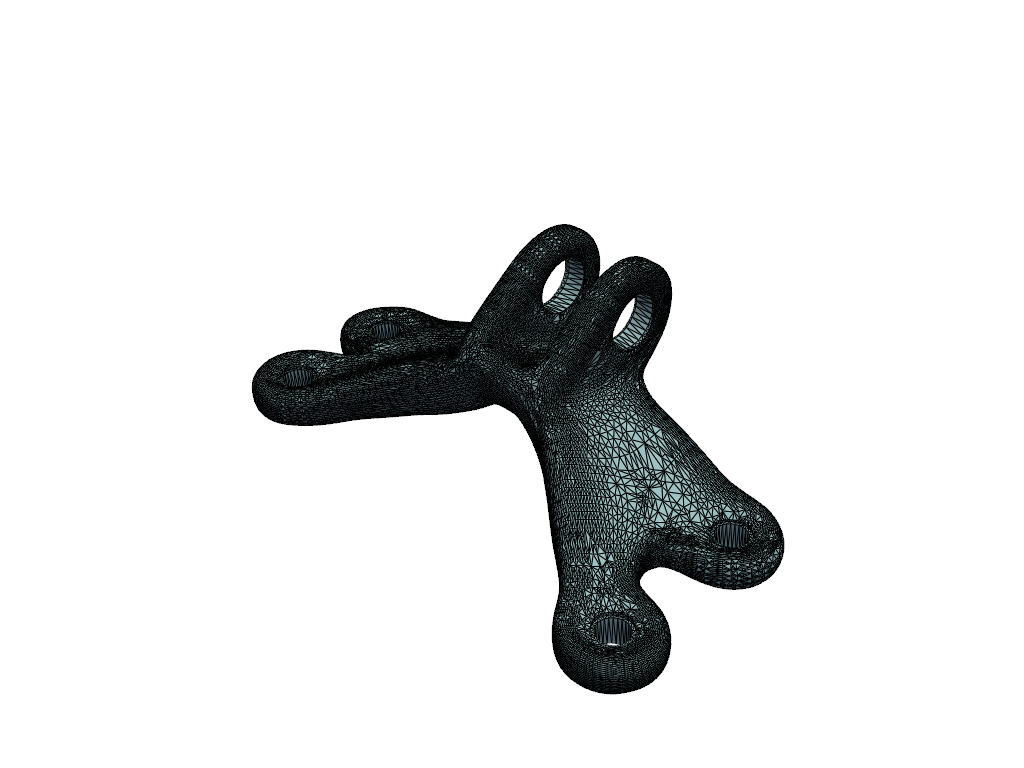

In [28]:
# 기본 메시 시각화
try:
    if pv_mesh.n_points > 0:
        plotter = pv.Plotter()
        plotter.add_mesh(pv_mesh, color='lightblue', show_edges=True)
        plotter.show(title="STEP 파일에서 로드된 B-rep 메시")
    else:
        print("메시에 포인트가 없어 시각화할 수 없습니다.")
except Exception as e:
    print(f"시각화 중 오류 발생: {e}")

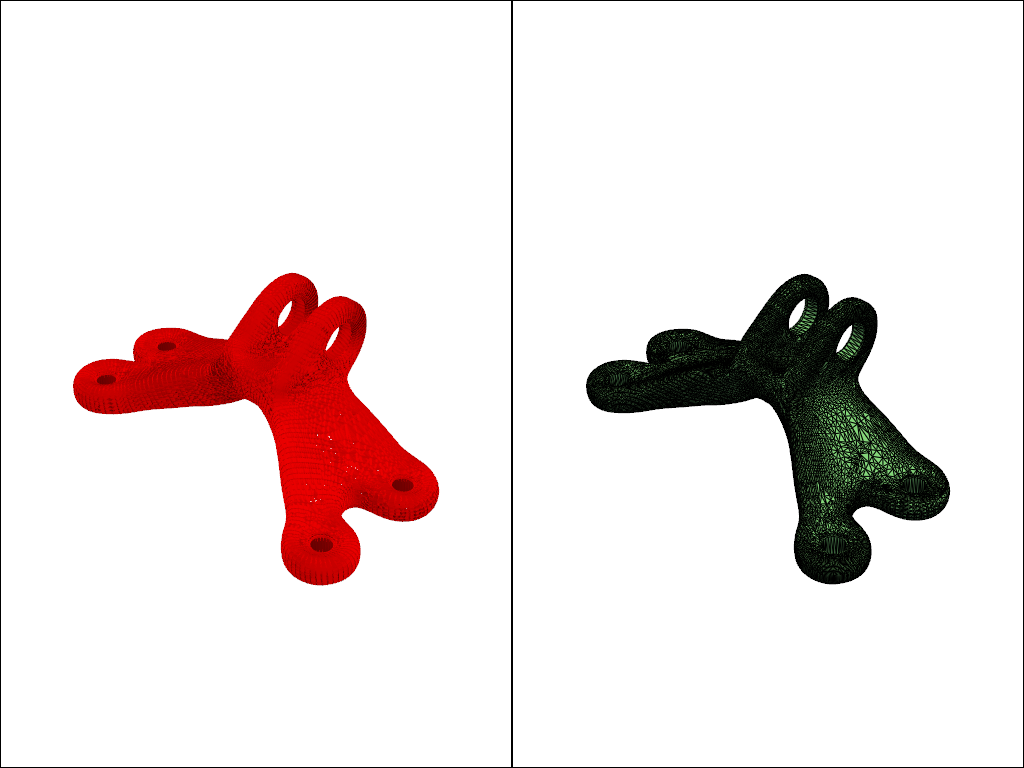

In [29]:
# 다양한 시각화 옵션
try:
    if pv_mesh.n_points > 0:
        # 1. 와이어프레임 모드
        plotter = pv.Plotter(shape=(1, 2))
        
        # 와이어프레임
        plotter.subplot(0, 0)
        plotter.add_mesh(pv_mesh, style='wireframe', color='red', line_width=2)
        plotter.add_title("와이어프레임 모드")
        
        # 솔리드 모드
        plotter.subplot(0, 1)
        plotter.add_mesh(pv_mesh, color='lightgreen', show_edges=True, edge_color='black')
        plotter.add_title("솔리드 모드")
        
        plotter.show(title="STEP B-rep 메시 - 다양한 표시 모드")
    else:
        print("메시에 포인트가 없어 시각화할 수 없습니다.")
    
except Exception as e:
    print(f"다중 시각화 중 오류 발생: {e}")

In [30]:
# 메시 정보 및 통계
try:
    print("=== 메시 상세 정보 ===")
    print(f"포인트 개수: {pv_mesh.n_points}")
    print(f"셀 개수: {pv_mesh.n_cells}")
    
    if pv_mesh.n_points > 0:
        print(f"메시 바운드: {pv_mesh.bounds}")
        print(f"메시 중심: {pv_mesh.center}")
        print(f"메시 볼륨: {pv_mesh.volume:.2f}")
        print(f"메시 표면적: {pv_mesh.area:.2f}")
        
        # 메시 품질 분석
        if hasattr(pv_mesh, 'quality'):
            quality = pv_mesh.quality
            print(f"메시 품질 통계:")
            print(f"  - 최소 품질: {quality.min():.4f}")
            print(f"  - 최대 품질: {quality.max():.4f}")
            print(f"  - 평균 품질: {quality.mean():.4f}")
    else:
        print("메시가 비어있어 상세 정보를 계산할 수 없습니다.")
    
except Exception as e:
    print(f"메시 정보 분석 중 오류 발생: {e}")

=== 메시 상세 정보 ===
포인트 개수: 21056
셀 개수: 42130
메시 바운드: BoundsTuple(x_min=-38.91002655029297, x_max=70.0633773803711, y_min=-163.46083068847656, y_max=20.28745460510254, z_min=0.24451135098934174, z_max=65.3957748413086)
메시 중심: (15.576675415039062, -71.58668804168701, 32.82014309614897)
메시 볼륨: 175323.39
메시 표면적: 33959.96


In [31]:
# 메시 품질 시각화 (가능한 경우)
try:
    if pv_mesh.n_points > 0:
        if hasattr(pv_mesh, 'quality'):
            plotter = pv.Plotter()
            plotter.add_mesh(pv_mesh, scalars='quality', show_edges=True, cmap='viridis')
            plotter.add_scalar_bar(title="메시 품질")
            plotter.show(title="STEP B-rep 메시 품질 분석")
        else:
            print("메시 품질 정보를 사용할 수 없습니다.")
            
            # 대신 포인트 좌표를 기반으로 한 색상 매핑
            plotter = pv.Plotter()
            plotter.add_mesh(pv_mesh, scalars='z', show_edges=True, cmap='viridis')
            plotter.add_scalar_bar(title="Z 좌표")
            plotter.show(title="STEP B-rep 메시 - Z 좌표 기반 색상")
    else:
        print("메시가 비어있어 시각화할 수 없습니다.")
        
except Exception as e:
    print(f"품질 시각화 중 오류 발생: {e}")

메시 품질 정보를 사용할 수 없습니다.
품질 시각화 중 오류 발생: 'Data array (z) not present in this dataset.'


In [32]:
# 메시 저장 (선택사항)
try:
    if pv_mesh.n_points > 0:
        # STL 파일로 저장
        output_stl = '../../data/25_12_converted.stl'
        pv_mesh.save(output_stl)
        print(f"메시가 {output_stl}에 저장되었습니다.")
        
        # VTK 파일로 저장
        output_vtk = '../../data/25_12_converted.vtk'
        pv_mesh.save(output_vtk)
        print(f"메시가 {output_vtk}에 저장되었습니다.")
    else:
        print("메시가 비어있어 저장할 수 없습니다.")
    
except Exception as e:
    print(f"메시 저장 중 오류 발생: {e}")

메시가 ../../data/25_12_converted.stl에 저장되었습니다.
메시가 ../../data/25_12_converted.vtk에 저장되었습니다.


## 대안 방법: 다른 라이브러리 사용

FreeCAD가 제대로 작동하지 않는 경우, 다른 라이브러리를 사용할 수도 있습니다.

In [11]:
# 대안: OCP (OpenCascade) 라이브러리 사용
try:
    import OCP
    from OCP.BRep import BRep_Builder
    from OCP.TopoDS import TopoDS_Shape
    from OCP.STEPControl import STEPControl_Reader
    from OCP.BRepMesh import BRepMesh_IncrementalMesh
    
    print("OCP 라이브러리 사용 가능")
    
    # STEP 파일 읽기
    reader = STEPControl_Reader()
    reader.ReadFile(step_filepath)
    reader.TransferRoots()
    shape = reader.OneShape()
    
    # 메시 생성
    mesh = BRepMesh_IncrementalMesh(shape, 0.1)
    mesh.Perform()
    
    print("OCP를 사용한 메시 생성 완료")
    
except ImportError:
    print("OCP 라이브러리가 설치되어 있지 않습니다.")
    print("설치 방법: pip install OCP-stubs")
except Exception as e:
    print(f"OCP 사용 중 오류 발생: {e}")

OCP 라이브러리가 설치되어 있지 않습니다.
설치 방법: pip install OCP-stubs


## 요약

이 노트북에서는 다음 작업을 수행했습니다:

1. **FreeCAD Python 모듈을 사용하여 STEP 파일 로드**: B-rep 데이터를 직접 읽어들였습니다.
2. **B-rep을 메시로 변환**: FreeCAD의 Mesh 모듈을 올바르게 사용하여 B-rep을 삼각형 메시로 변환했습니다.
3. **PyVista 메시로 변환**: FreeCAD 메시 데이터를 PyVista가 이해할 수 있는 형태로 변환했습니다.
4. **다양한 시각화**: 와이어프레임, 솔리드 모드, 품질 분석 등 다양한 시각화를 제공했습니다.
5. **메시 정보 분석**: 포인트 개수, 셀 개수, 볼륨, 표면적 등의 정보를 분석했습니다.

### 수정된 부분:
- `Mesh.Mesh()` 생성자에 shape를 직접 전달하는 올바른 방법 사용
- 메시 데이터 변환 과정에서 더 자세한 디버깅 정보 추가
- 빈 메시에 대한 처리 개선

### 주의사항:
- FreeCAD가 시스템에 설치되어 있어야 합니다.
- 메시 변환 시 `tolerance`와 `angularDeflection` 파라미터를 조정하여 메시 품질을 제어할 수 있습니다.
- 큰 STEP 파일의 경우 메시 변환에 시간이 걸릴 수 있습니다.
- FreeCAD가 작동하지 않는 경우 OCP 라이브러리를 대안으로 사용할 수 있습니다.